# Clustering - Sleep Labels

This notebook is used to produce results related to clustering of data from the fitbit vitals data loaded from the corresponding pickle files and using sleep efficiency labels to then further find cluster impurities, distrinution and good sleep reciepes

## Importing Required Libraries

In [1]:
# Importing scientific libarires required for analysis and handling data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Importing libraries related to handling of files and directory
import os
import glob
import pickle
import random

# Importing utility functions from the code base
from utils.directory_utils import *
from utils.general_utils import *
from utils.sleep_utils import *
from data_preprocessor.get_user_data import *
from clustering_utils import *

# Importing Machine Learning utilities
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.spatial import distance
from tslearn.metrics import dtw, cdist_dtw

## Data

This section loads all different types of data from the pickle files that we have saved and then loads the relevant data into numpy array for further analysis

### Heart Rate, Sleep, Calories and Activity Time Series Data

#### User Data Loader

In [132]:
# First we load the data for each user seperately from their own numpy array and then stack them to get the final array
numpy_array_directory = f'../data/data_numpy_arrays/'

heart_rate_ts_data = []
calories_ts_data = []
activity_label_ts_data = []
activity_percentages = []
sleep_effeciency_ratio = []
sleep_stages_summary = []

for user_name in get_subdirectory_nms(numpy_array_directory):
    user_directory = construct_path(numpy_array_directory, user_name)
    
    user_heart_rate_ts_data = np.load(construct_path(user_directory, f'norm_heart_rate_ts_data.npy'))
    user_calories_ts_data = np.load(construct_path(user_directory, f'norm_calories_ts_data.npy'))
    user_activity_label_ts_data = np.load(construct_path(user_directory, f'activity_label_ts_data.npy'))
    user_activity_percentages = np.load(construct_path(user_directory, f'activity_percentages.npy'))
    user_sleep_effeciency_ratio = np.load(construct_path(user_directory, f'sleep_efficiency_ratio.npy'))
    user_sleep_stages_summary = pd.read_csv(construct_path(user_directory, f'sleep_stages_summary.csv'))
    
    heart_rate_ts_data.append(user_heart_rate_ts_data)
    calories_ts_data.append(user_calories_ts_data)
    activity_label_ts_data.append(user_activity_label_ts_data)
    activity_percentages.append(user_activity_percentages)
    sleep_effeciency_ratio.append(user_sleep_effeciency_ratio)
    sleep_stages_summary.append(user_sleep_stages_summary)
    
heart_rate_ts_data = np.vstack(heart_rate_ts_data)[:, :]
calories_ts_data = np.vstack(calories_ts_data)[:, :]
activity_label_ts_data = np.vstack(activity_label_ts_data)[:, :]
activity_percentages = np.vstack(activity_percentages)
sleep_effeciency_ratio = np.hstack(sleep_effeciency_ratio)
sleep_stages_summary = pd.concat(sleep_stages_summary)

In [2]:
# heart_rate_ts_data = np.load(f'../data/data_numpy_arrays/Saksham/heart_rate_ts_data.npy')
# calories_ts_data = np.load(f'../data/data_numpy_arrays/Saksham/calories_ts_data.npy')
# activity_label_ts_data = np.load(f'../data/data_numpy_arrays/Saksham/activity_label_ts_data.npy')
# activity_percentages = np.load(f'../data/data_numpy_arrays/Saksham/activity_percentages.npy')
# sleep_effeciency_ratio = np.load(f'../data/data_numpy_arrays/Saksham/sleep_efficiency_ratio.npy')
# sleep_stages_summary = pd.read_csv(f'../data/data_numpy_arrays/Saksham/sleep_stages_summary.csv')

#### Check for the shape of all the arrays and dataframes

In [133]:
# Check for the shape of all the arrays and dataframes
heart_rate_ts_data.shape, calories_ts_data.shape, activity_label_ts_data.shape, sleep_effeciency_ratio.shape, sleep_stages_summary.shape

((100, 1440), (100, 1440), (100, 1440), (100,), (100, 4))

In [134]:
# Make sure activity value does not have a nan field (not sure how we would fill this)
print(np.isnan(activity_label_ts_data).any())
# Check that no nans in any of the data
np.isnan(heart_rate_ts_data).any(), np.isnan(calories_ts_data).any()

False


(False, False)

### Heart Rate and Calories Trends

This section will essentially find the trends from the original data

In [135]:
trend_window_length = 15

#### Heart Trends

In [136]:
heart_trends = []
counter = 0
for day in heart_rate_ts_data:
    counter += 1
    result = seasonal_decompose(day, model='additive', freq=trend_window_length, extrapolate_trend='freq')
    heart_trends.append(result.trend)
heart_trends = np.array(heart_trends)
heart_trends = remove_nans_from_array(heart_trends)
# Make sure the shape is same and there are no nan values
heart_trends.shape, np.isnan(heart_trends).any()

((100, 1440), False)

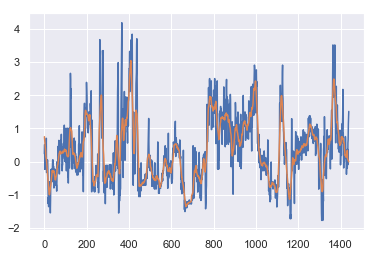

In [137]:
# plotting heart trends to asses the fit to the overall data
plt.plot(heart_rate_ts_data[0, :])
plt.plot(heart_trends[0, :])

#### Calories Trends

In [138]:
calories_trends = []
for day in calories_ts_data:
    result = seasonal_decompose(day, model='additive', freq=trend_window_length, extrapolate_trend='freq')
    calories_trends.append(result.trend)
calories_trends = np.array(calories_trends)
calories_trends = remove_nans_from_array(calories_trends)
# Make sure the shape is same and there are no nan values
calories_trends.shape, np.isnan(calories_trends).any()

((100, 1440), False)

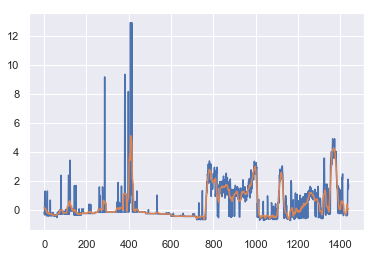

In [139]:
# plotting caloires trends to asses the fit to the overall data
plt.plot(calories_ts_data[0, :])
plt.plot(calories_trends[0, :])

### Dimensionality Reduction

This section will reduce the dimensions of the arrays so that we can easily apply different clustering techniques on them

In [224]:
mean_window_length = 60

In [225]:
# Reduce the dimension of the arrays
reduced_heart_trends = reduce_time_series_dimension(heart_trends, mean_window_length)
reduced_calories_trends = reduce_time_series_dimension(calories_trends, mean_window_length)
# Check for the shape of the arrays
reduced_heart_trends.shape, reduced_calories_trends.shape

((100, 24), (100, 24))

## Sleep Labels

In this section of the notebook we try to find the optimal boundary for constructing the sleep labels using different techniques

Text(0.5, 1.0, 'Sleep Efficiency Histogram')

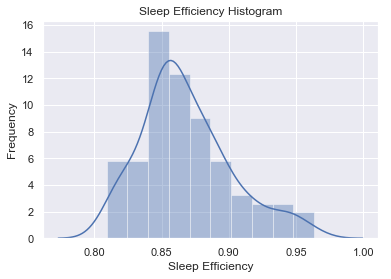

In [226]:
# Constructing a histogram plot for the sleep efficiency ratio.
# Sleep Efficiency Ratio is found as total_time_asleep / total_time_in_bed
sns.distplot(sleep_effeciency_ratio)
plt.xlabel('Sleep Efficiency')
plt.ylabel('Frequency')
plt.title('Sleep Efficiency Histogram')

Text(0.5, 1.0, 'Minutes in Deep Sleep Histogram')

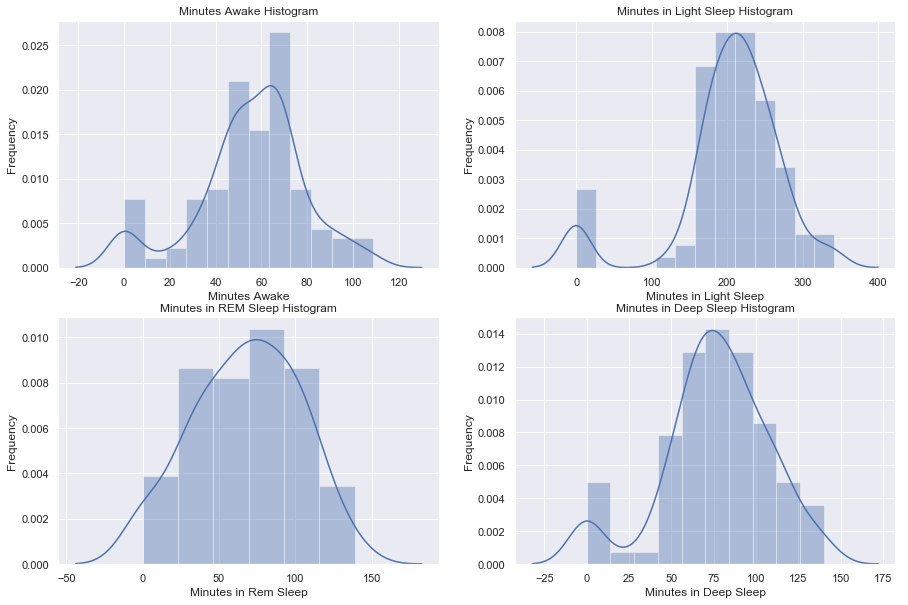

In [227]:
# Constructing a histogram plot for the different sleep stages.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(sleep_stages_summary['wake'], ax = ax[0, 0])
ax[0, 0].set_xlabel('Minutes Awake')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Minutes Awake Histogram')

sns.distplot(sleep_stages_summary['light'], ax = ax[0, 1])
ax[0, 1].set_xlabel('Minutes in Light Sleep')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Minutes in Light Sleep Histogram')

sns.distplot(sleep_stages_summary['rem'], ax = ax[1, 0])
ax[1, 0].set_xlabel('Minutes in Rem Sleep')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Minutes in REM Sleep Histogram')

sns.distplot(sleep_stages_summary['deep'], ax = ax[1, 1])
ax[1, 1].set_xlabel('Minutes in Deep Sleep')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Minutes in Deep Sleep Histogram')

### Gap Definition For Sleep Efficiency

Create a gap of certain length: Which will be a __parameter__

Example: 0.05 - 0.875 and above, 0.825 and below

In [228]:
final_sleep_labels = sleep_effeciency_ratio > 0.86

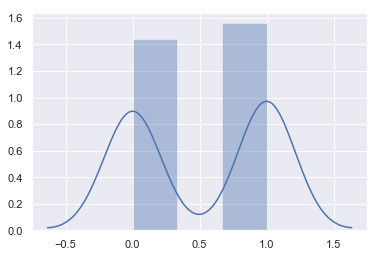

In [229]:
sns.distplot(np.array(final_sleep_labels, dtype=np.int))

### HeatMap for Euclidean and DTW Distances

In [230]:
good_sleep_heart_trends = reduced_heart_trends[final_sleep_labels]
poor_sleep_heart_trends = reduced_heart_trends[~final_sleep_labels]
print(good_sleep_heart_trends.shape, poor_sleep_heart_trends.shape)
ordered_heart_trends = np.vstack((good_sleep_heart_trends, poor_sleep_heart_trends))
print(ordered_heart_trends.shape)

(52, 24) (48, 24)
(100, 24)


In [231]:
good_sleep_calories_trends = reduced_calories_trends[final_sleep_labels]
poor_sleep_calories_trends = reduced_calories_trends[~final_sleep_labels]
print(good_sleep_calories_trends.shape, poor_sleep_calories_trends.shape)
ordered_calories_trends = np.vstack((good_sleep_calories_trends, poor_sleep_calories_trends))
print(ordered_calories_trends.shape)

(52, 24) (48, 24)
(100, 24)


In [232]:
%%time
dtw_dist_heart = cdist_dtw(ordered_heart_trends)
dtw_dist_calories = cdist_dtw(ordered_calories_trends)
euc_dist_heart = distance.cdist(ordered_heart_trends, ordered_heart_trends)
euc_dist_calories = distance.cdist(ordered_calories_trends, ordered_calories_trends)

Wall time: 3.89 s


In [238]:
m_dist_heart = distance.cdist(ordered_heart_trends, ordered_heart_trends, 'mahalanobis')
m_dist_calories = distance.cdist(ordered_calories_trends, ordered_calories_trends, 'mahalanobis')
l1_dist_heart = distance.cdist(ordered_heart_trends, ordered_heart_trends, 'minkowski', p=1)
l1_dist_calories = distance.cdist(ordered_calories_trends, ordered_calories_trends, 'minkowski', p=1)

Text(0.5, 1.0, 'All Sleep DTW Distance Cross Matrix for Calories Trends')

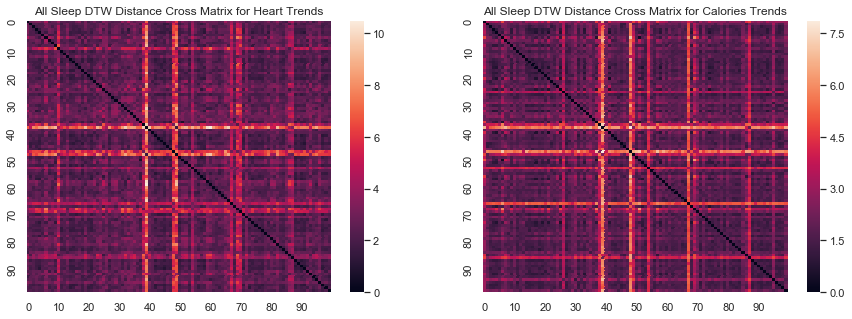

In [234]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(dtw_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep DTW Distance Cross Matrix for Heart Trends')
sns.heatmap(dtw_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep DTW Distance Cross Matrix for Calories Trends')

Text(0.5, 1.0, 'All Sleep Euclidean Distance Cross Matrix for Calories Trends')

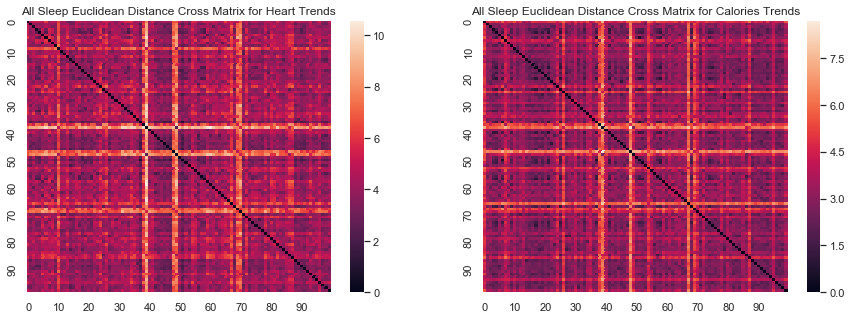

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(euc_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep Euclidean Distance Cross Matrix for Heart Trends')
sns.heatmap(euc_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep Euclidean Distance Cross Matrix for Calories Trends')

Text(0.5, 1.0, 'All Sleep Mahalanobis Distance Cross Matrix for Calories Trends')

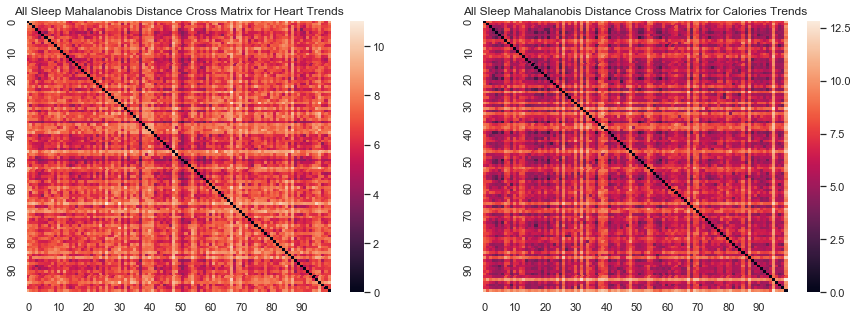

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(m_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep Mahalanobis Distance Cross Matrix for Heart Trends')
sns.heatmap(m_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep Mahalanobis Distance Cross Matrix for Calories Trends')

Text(0.5, 1.0, 'All Sleep L1 Norm Distance Cross Matrix for Calories Trends')

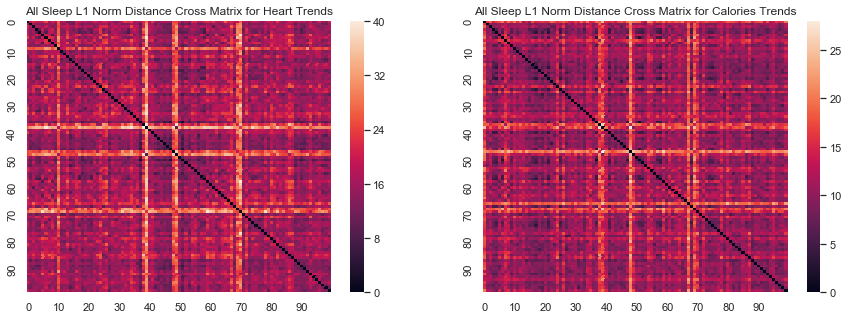

In [239]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(l1_dist_heart, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_title('All Sleep L1 Norm Distance Cross Matrix for Heart Trends')
sns.heatmap(l1_dist_calories, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_title('All Sleep L1 Norm Distance Cross Matrix for Calories Trends')

## Activity Percentages

In this section of the notebook we aggregate the activity labels of a person from minute level to percentage level

Text(0.5, 1.0, '% Vigorous Activity Histogram')

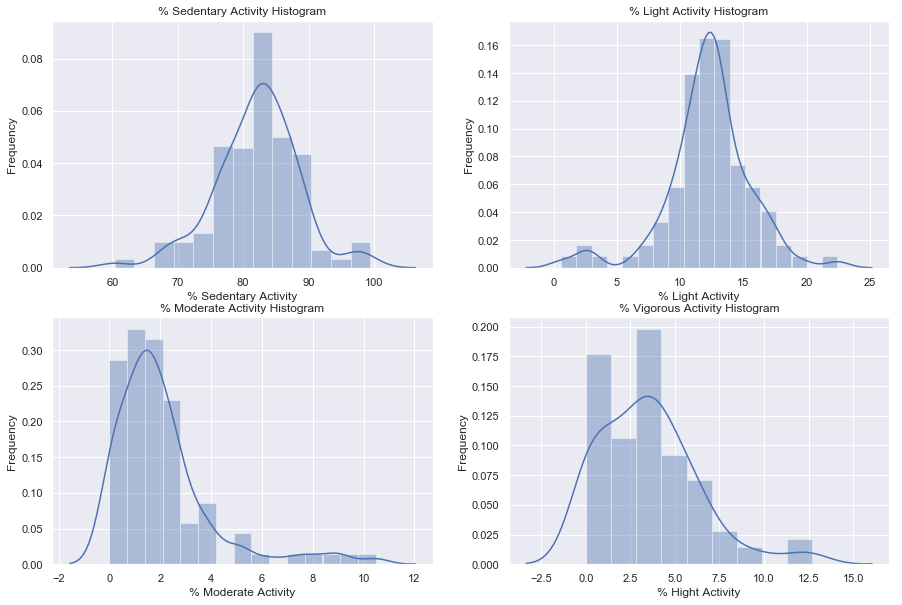

In [240]:
# Constructing a histogram plot for the different activity level percentages.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[:, 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[:, 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[:, 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[:, 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

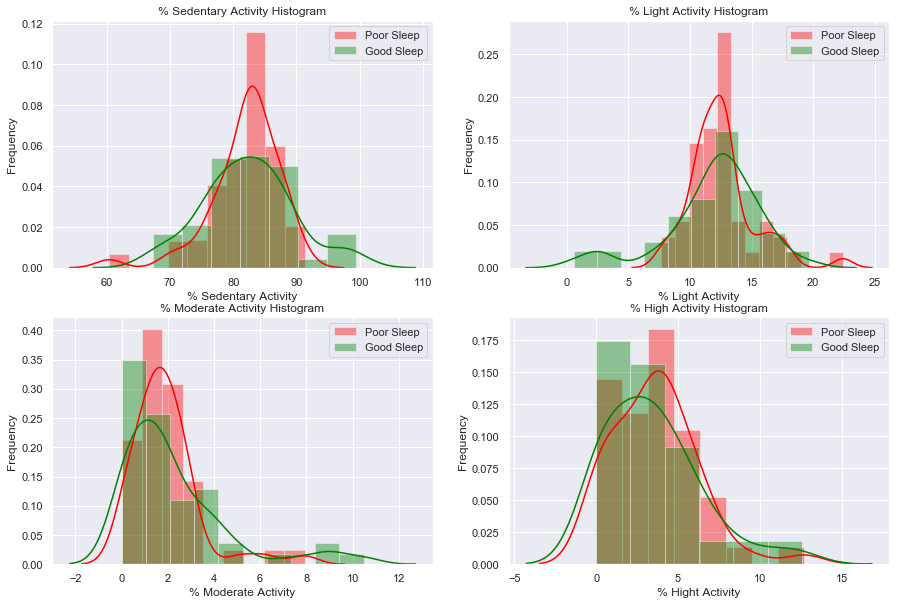

In [241]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[~final_sleep_labels, 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')
ax[1, 1].legend()

## Clustering

In this section of the notebook we apply different clustering techniques on the data that we have got and see what are the different recipes

In [259]:
num_master_clusters = 4
num_activity_clusters = 8

### K-Means - Euclidean

Here we apply K-Means on the data with euclidean (L-2 Norm) as the distance metric

#### Fitting the Model

In [261]:
# Set the seed so that get the same clustering everytime
random.seed(2)
np.random.seed(200)
# Performing the Clustering
kmeans_mod = KMeans(n_clusters=num_master_clusters)
kmeans_mod.fit(reduced_heart_trends)
cluster_assignments = kmeans_mod.predict(reduced_heart_trends)
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2, 3]), array([14, 33, 42, 11], dtype=int64))

In [262]:
# Update the number of activity clusters based on the minimum amount of records assigned to a cluster
num_activity_clusters = min(num_activity_clusters, *(np.unique(cluster_assignments, return_counts=True)[1]))
print('Updated Number of activity clusters:', num_activity_clusters)

Updated Number of activity clusters: 8


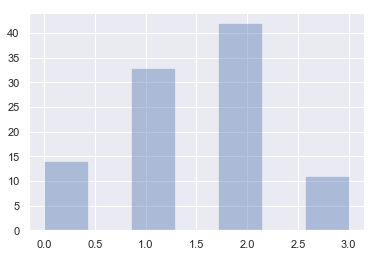

In [263]:
# Visualizing the number of points in each cluster
sns.distplot(cluster_assignments, kde=False)

#### Visualization of Clusters

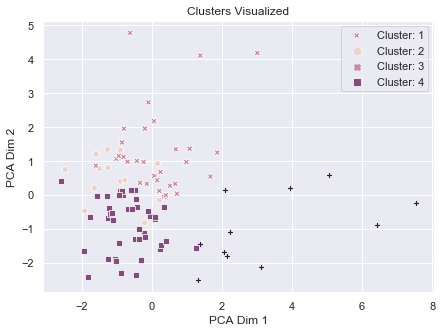

In [264]:
# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([f'Cluster: {i+1}' for i in range(4)])

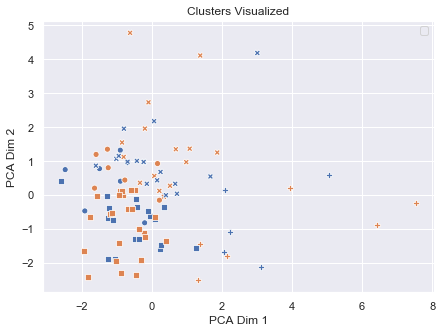

In [265]:
# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([])

#### Cluster Purity

Finding cluster purity based on the sleep labels

In [266]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster 
# to total number of instances in the cluster
for master_cluster_num in range(num_master_clusters):
    cluster_sleep_labels = final_sleep_labels[cluster_assignments == master_cluster_num]
    pos_sleep_label_purity = sum(cluster_sleep_labels) / cluster_sleep_labels.shape[0]
    print(f'Cluster Number: {master_cluster_num}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))

Cluster Number: 0, Purity: 0.5
Cluster Number: 1, Purity: 0.5454545454545454
Cluster Number: 2, Purity: 0.5714285714285714
Cluster Number: 3, Purity: 0.5454545454545454


Text(0.5, 1.0, 'Cluster 4')

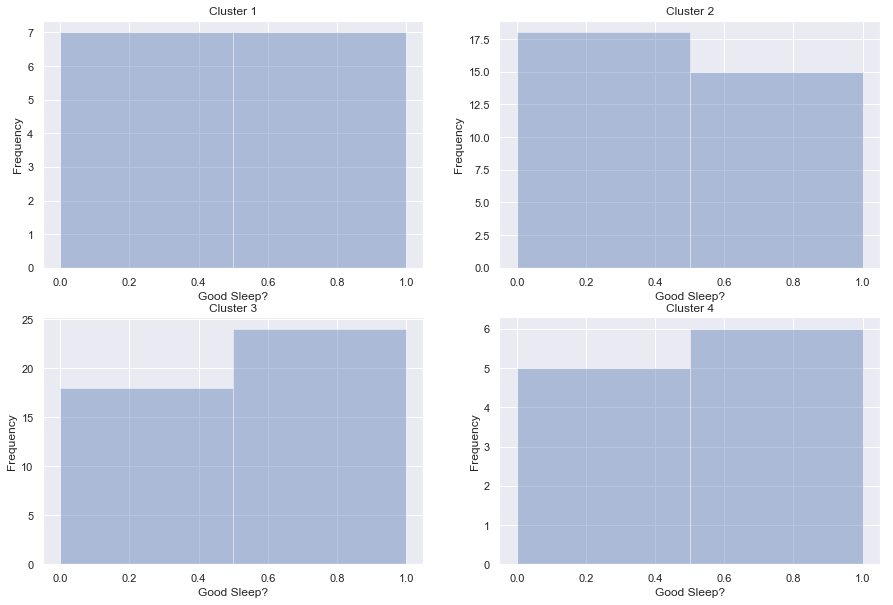

In [267]:
# Constructing a histogram plot for visualizing the sleep efficiency cluster purity in all cluster.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(np.array(final_sleep_labels[cluster_assignments==0], dtype=np.int16), ax = ax[0, 0], kde=False)
ax[0, 0].set_xlabel('Good Sleep?')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Cluster 1')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==1], dtype=np.int16), ax = ax[0, 1], kde=False)
ax[0, 1].set_xlabel('Good Sleep?')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Cluster 2')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==2], dtype=np.int16), ax = ax[1, 0], kde=False)
ax[1, 0].set_xlabel('Good Sleep?')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Cluster 3')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==3], dtype=np.int16), ax = ax[1, 1], kde=False)
ax[1, 1].set_xlabel('Good Sleep?')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Cluster 4')

#### Activity Histograms for Clusters

#### Cluster: 1

Text(0.5, 1.0, '% Vigorous Activity Histogram')

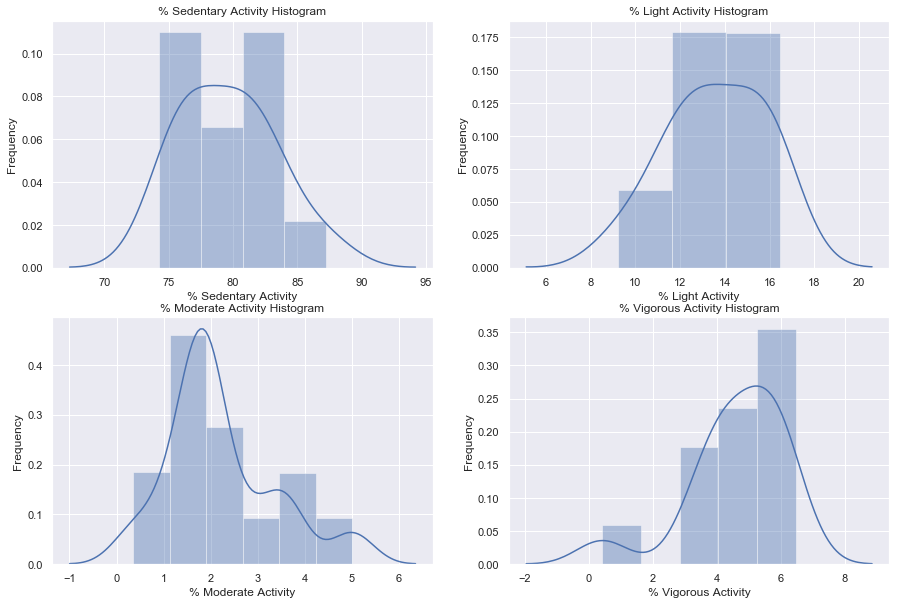

In [268]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

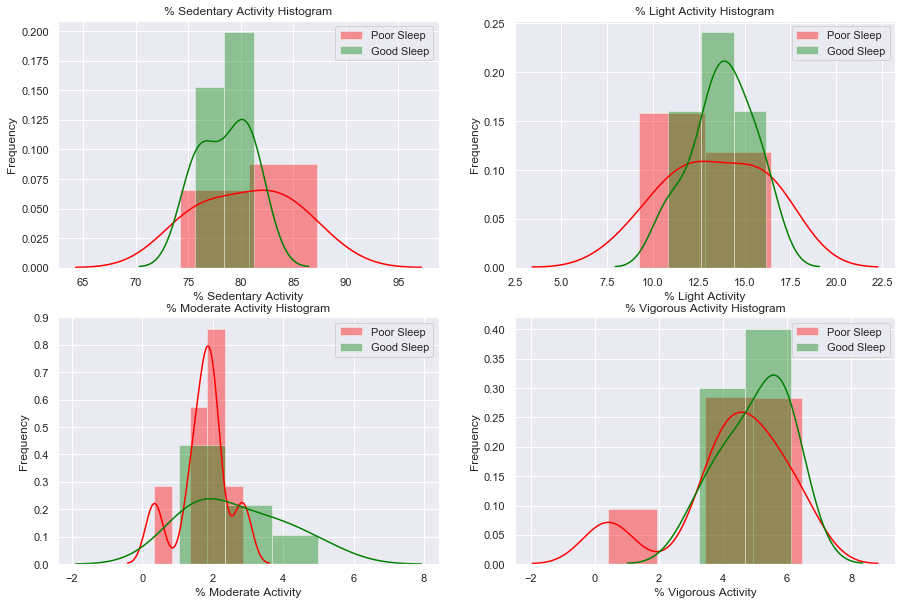

In [269]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 2

Text(0.5, 1.0, '% Vigorous Activity Histogram')

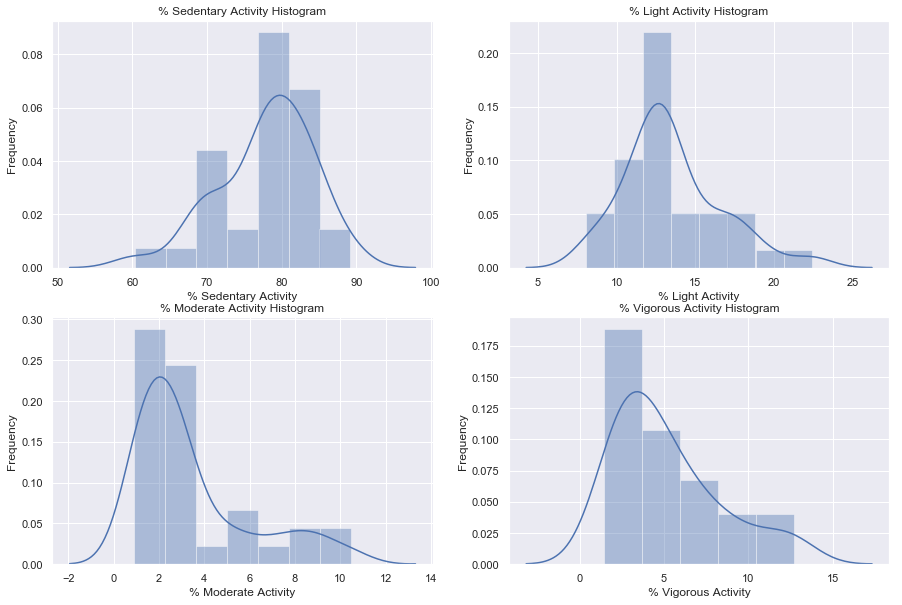

In [270]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

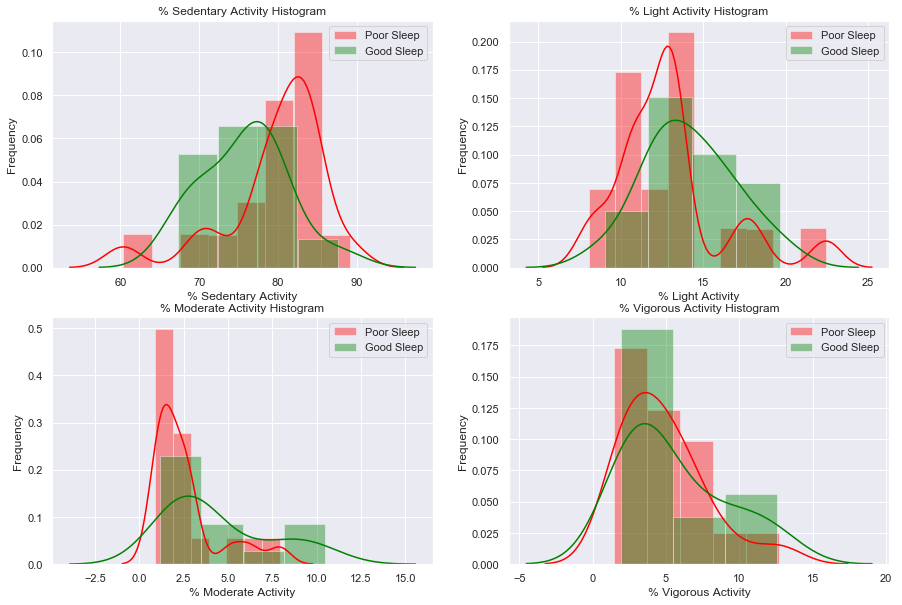

In [271]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 3

Text(0.5, 1.0, '% Vigorous Activity Histogram')

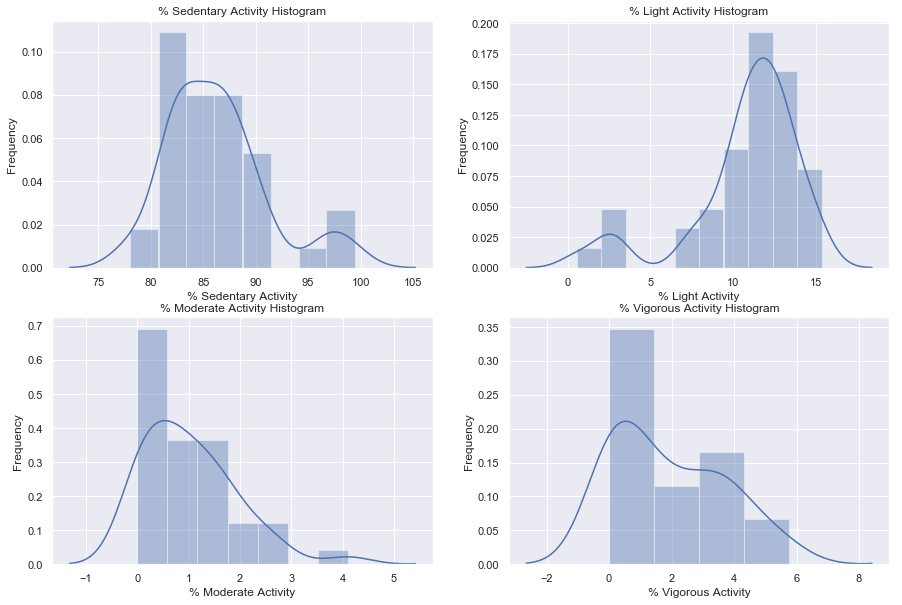

In [272]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

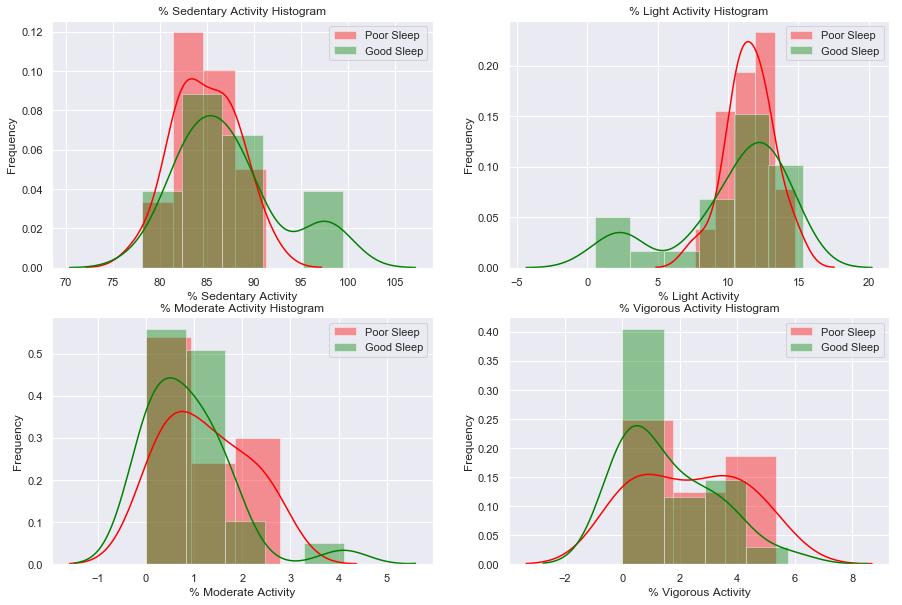

In [273]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 4

Text(0.5, 1.0, '% Vigorous Activity Histogram')

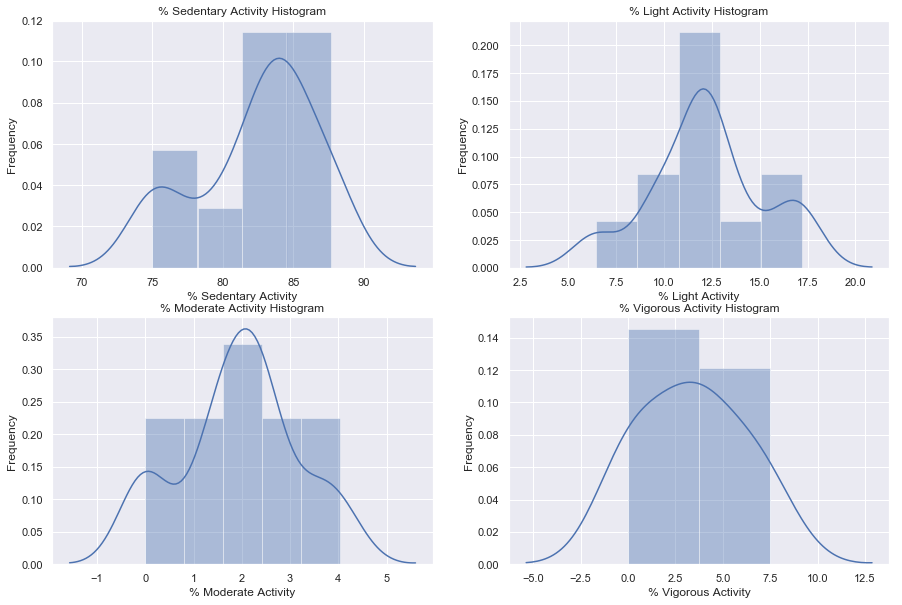

In [274]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

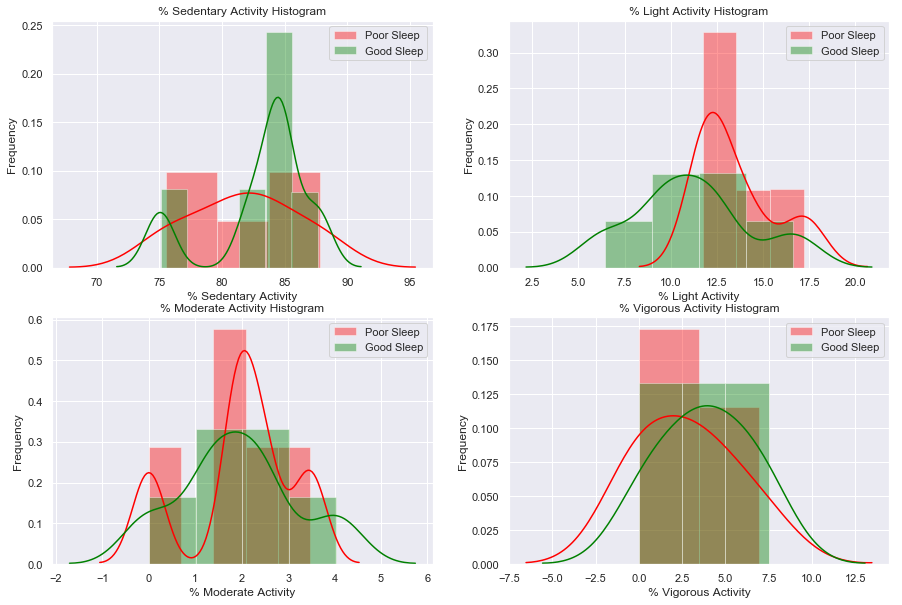

In [275]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Sub-Clustering on Activity Data

In [276]:
sub_clusters = activity_percentage_clusterer(KMeans(n_clusters=num_activity_clusters), None, cluster_assignments, activity_percentages)

In [277]:
# Sanity Check for the number of points in each cluster
print(np.unique(cluster_assignments, return_counts=True))
for sub_cluster in sub_clusters:
    print(sub_cluster.shape)

(array([0, 1, 2, 3]), array([14, 33, 42, 11], dtype=int64))
(14,)
(33,)
(42,)
(11,)


##### Cluster Purity in each subcluster

In [278]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster
# to total number of instances in the cluster
for index, sub_cluster in enumerate(sub_clusters):
    print('Master Cluster:', index+1)
    cluster_sleep_labels = final_sleep_labels[(cluster_assignments == index)]
    for sub_cluster_assignment in range(num_activity_clusters):
        sub_cluster_sleep_labels = cluster_sleep_labels[(sub_cluster==sub_cluster_assignment)]
        try:
            pos_sleep_label_purity = sum(sub_cluster_sleep_labels) / sub_cluster_sleep_labels.shape[0]
            print(f'Sub Cluster Number: {sub_cluster_assignment}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))
        except:
            print(f'Sub Cluster Number: {sub_cluster_assignment}, No Points assigned')

Master Cluster: 1
Sub Cluster Number: 0, Purity: 1.0
Sub Cluster Number: 1, Purity: 1.0
Sub Cluster Number: 2, Purity: 0.6666666666666666
Sub Cluster Number: 3, Purity: 1.0
Sub Cluster Number: 4, Purity: 0.6666666666666667
Sub Cluster Number: 5, Purity: 1.0
Sub Cluster Number: 6, Purity: 1.0
Sub Cluster Number: 7, Purity: 1.0
Master Cluster: 2
Sub Cluster Number: 0, Purity: 0.8888888888888888
Sub Cluster Number: 1, Purity: 0.6666666666666666
Sub Cluster Number: 2, Purity: 0.8333333333333334
Sub Cluster Number: 3, Purity: 1.0
Sub Cluster Number: 4, Purity: 1.0
Sub Cluster Number: 5, Purity: 0.5
Sub Cluster Number: 6, Purity: 0.6
Sub Cluster Number: 7, Purity: 0.75
Master Cluster: 3
Sub Cluster Number: 0, Purity: 0.6
Sub Cluster Number: 1, Purity: 1.0
Sub Cluster Number: 2, Purity: 0.6363636363636364
Sub Cluster Number: 3, Purity: 0.6
Sub Cluster Number: 4, Purity: 0.75
Sub Cluster Number: 5, Purity: 0.75
Sub Cluster Number: 6, Purity: 0.5
Sub Cluster Number: 7, Purity: 0.571428571428571

### K-Means - DTW

Here we apply K-Means on the data with Dynamic Time Wrapping (DTW) as the distance metric

#### Fitting the Model

In [279]:
%%time
# Setting the seed
random.seed(10)
np.random.seed(10)
clusterer = TimeSeriesKMeans(num_master_clusters, metric='dtw', max_iter=50)
clusterer.fit(reduced_heart_trends)
cluster_assignments = clusterer.predict(reduced_heart_trends)

4.777 --> 3.813 --> 3.766 --> 3.720 --> 3.718 --> 3.716 --> 3.706 --> 3.706 --> 
Wall time: 4.77 s


In [280]:
print(np.unique(cluster_assignments, return_counts=True))

(array([0, 1, 2, 3], dtype=int64), array([11, 20, 62,  7], dtype=int64))


In [281]:
# Update the number of activity clusters based on the minimum amount of records assigned to a cluster
num_activity_clusters = min(num_activity_clusters, *(np.unique(cluster_assignments, return_counts=True)[1]))
print('Updated Number of activity clusters:', num_activity_clusters)

Updated Number of activity clusters: 7


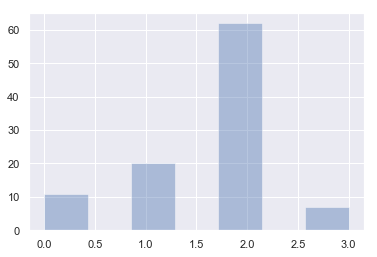

In [282]:
# Visualizing the number of points in each cluster
sns.distplot(cluster_assignments, kde=False)

#### Visualization of Clusters

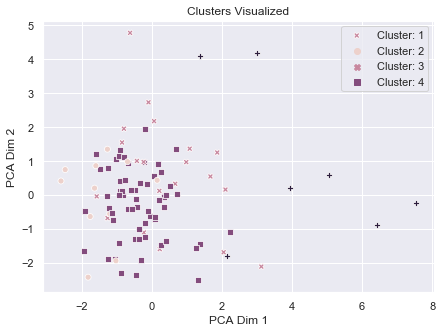

In [283]:
# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([f'Cluster: {i+1}' for i in range(4)])

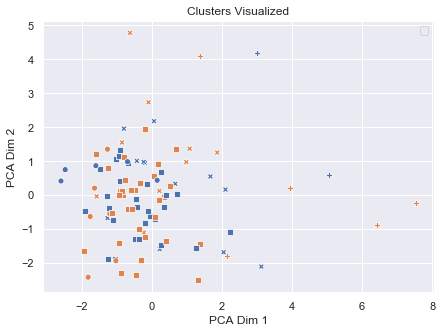

In [284]:
# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([])

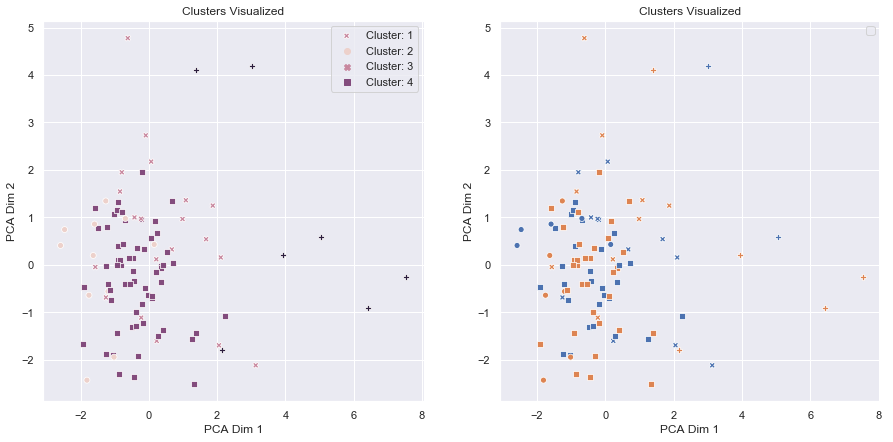

In [285]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments, ax=ax[0])
ax[0].set_xlabel('PCA Dim 1')
ax[0].set_ylabel('PCA Dim 2')
ax[0].set_title('Clusters Visualized')
ax[0].legend([f'Cluster: {i+1}' for i in range(4)])

# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments, ax=ax[1])
ax[1].set_xlabel('PCA Dim 1')
ax[1].set_ylabel('PCA Dim 2')
ax[1].set_title('Clusters Visualized')
ax[1].legend([])

#### Cluster Purity

Finding cluster purity based on the sleep labels

In [286]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster 
# to total number of instances in the cluster
for master_cluster_num in range(num_master_clusters):
    cluster_sleep_labels = final_sleep_labels[cluster_assignments == master_cluster_num]
    pos_sleep_label_purity = sum(cluster_sleep_labels) / cluster_sleep_labels.shape[0]
    print(f'Cluster Number: {master_cluster_num}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))

Cluster Number: 0, Purity: 0.5454545454545454
Cluster Number: 1, Purity: 0.55
Cluster Number: 2, Purity: 0.5161290322580645
Cluster Number: 3, Purity: 0.7142857142857143


Text(0.5, 1.0, 'Cluster 4')

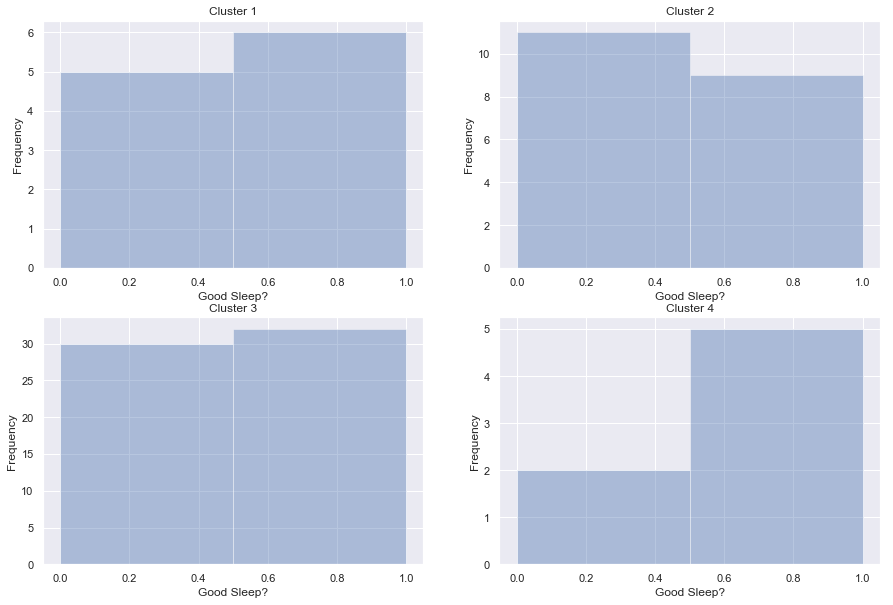

In [287]:
# Constructing a histogram plot for visualizing the sleep efficiency cluster purity in all cluster.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(np.array(final_sleep_labels[cluster_assignments==0], dtype=np.int16), ax = ax[0, 0], kde=False)
ax[0, 0].set_xlabel('Good Sleep?')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Cluster 1')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==1], dtype=np.int16), ax = ax[0, 1], kde=False)
ax[0, 1].set_xlabel('Good Sleep?')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Cluster 2')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==2], dtype=np.int16), ax = ax[1, 0], kde=False)
ax[1, 0].set_xlabel('Good Sleep?')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Cluster 3')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==3], dtype=np.int16), ax = ax[1, 1], kde=False)
ax[1, 1].set_xlabel('Good Sleep?')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Cluster 4')

#### Activity Histograms for Clusters

#### Cluster: 1

Text(0.5, 1.0, '% Vigorous Activity Histogram')

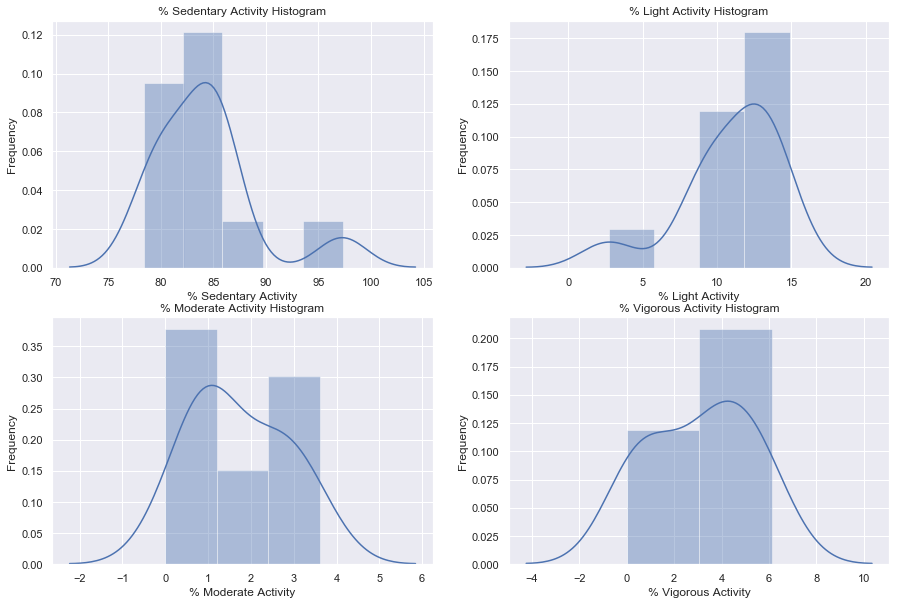

In [288]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

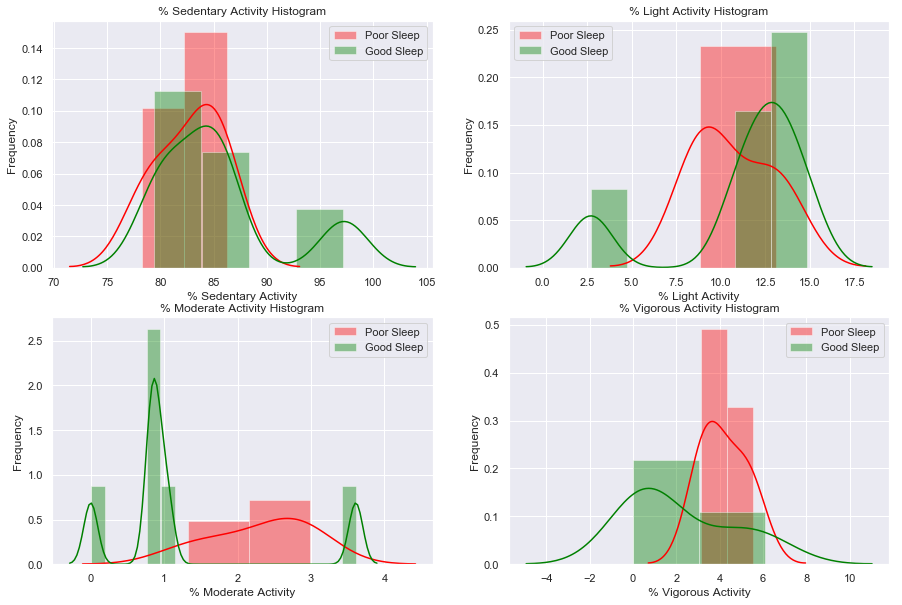

In [289]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 2

Text(0.5, 1.0, '% Vigorous Activity Histogram')

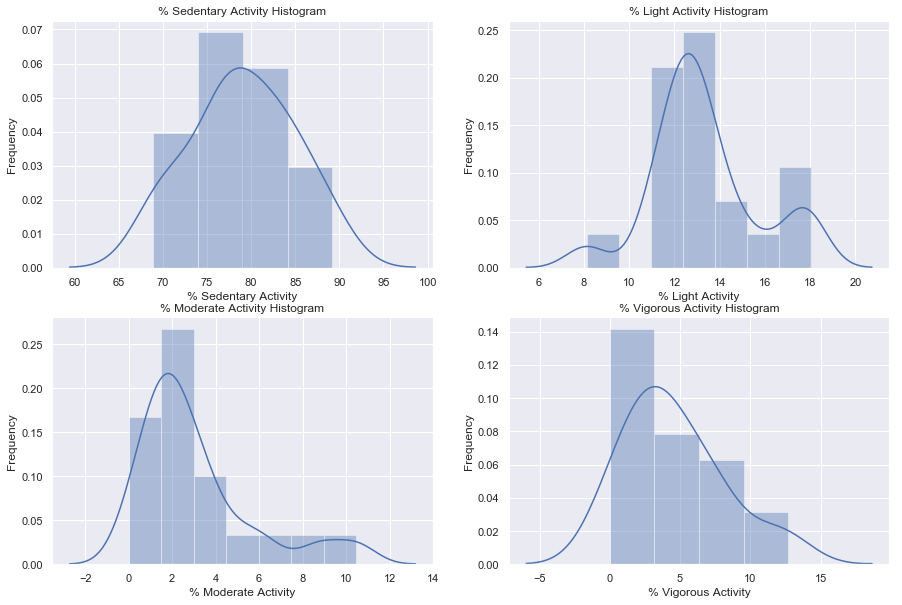

In [290]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

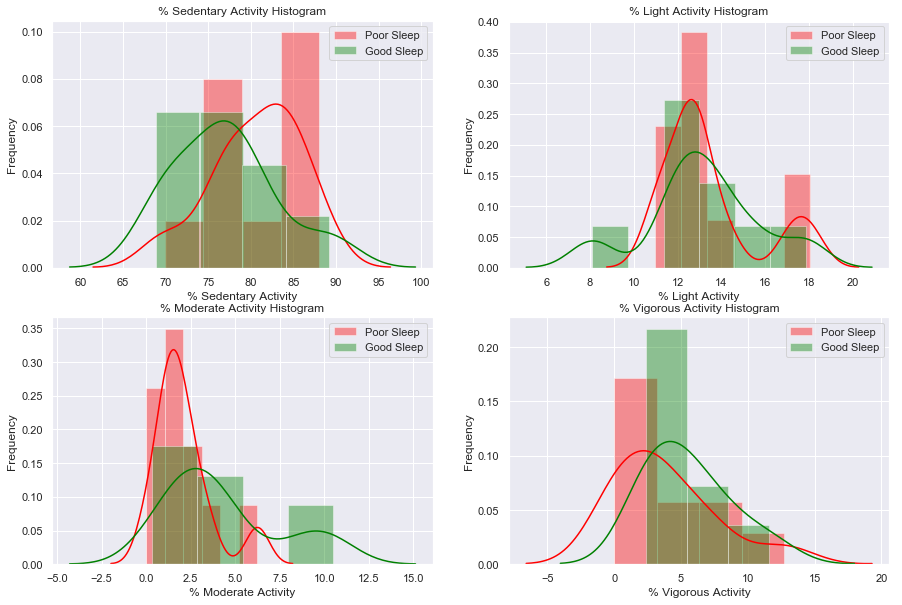

In [291]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 3

Text(0.5, 1.0, '% Vigorous Activity Histogram')

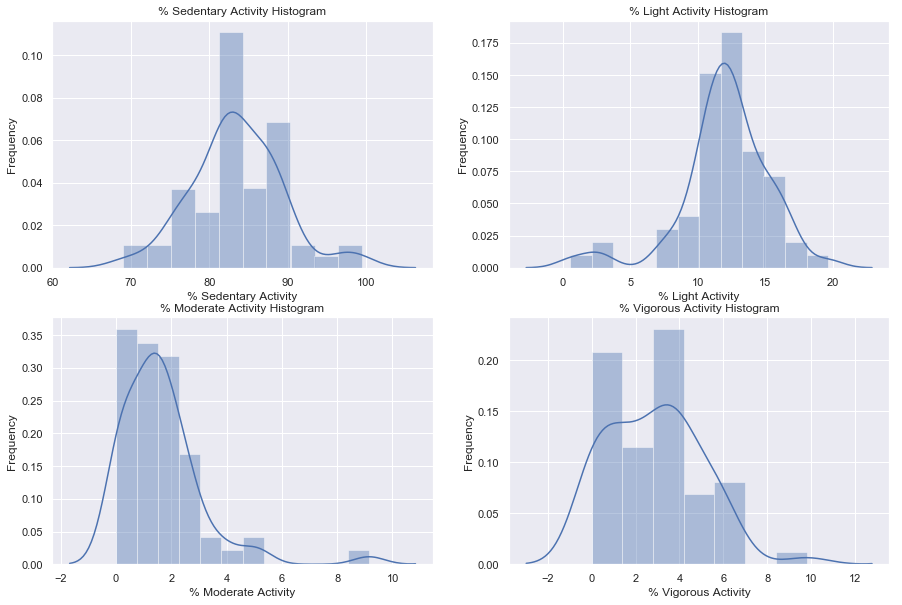

In [292]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

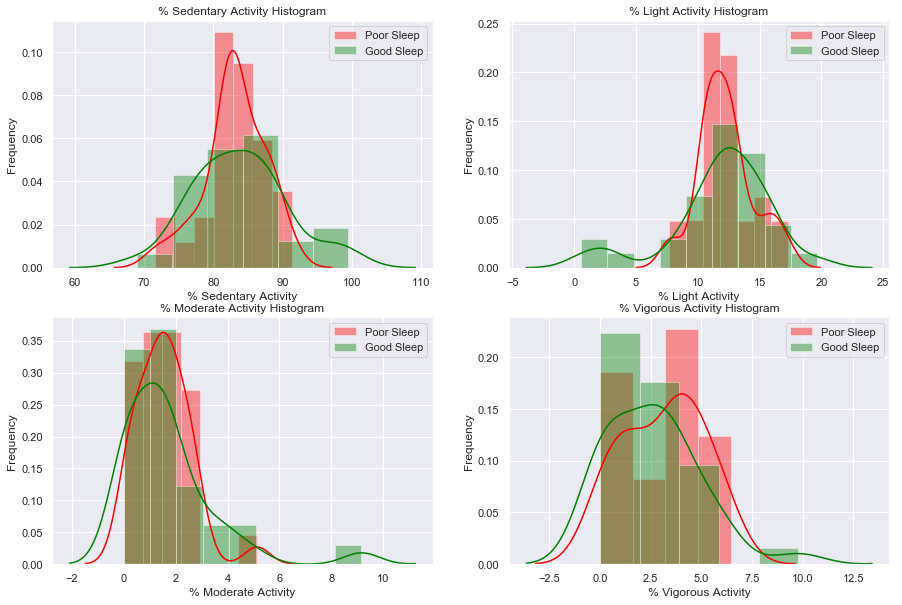

In [293]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Cluster: 4

Text(0.5, 1.0, '% Vigorous Activity Histogram')

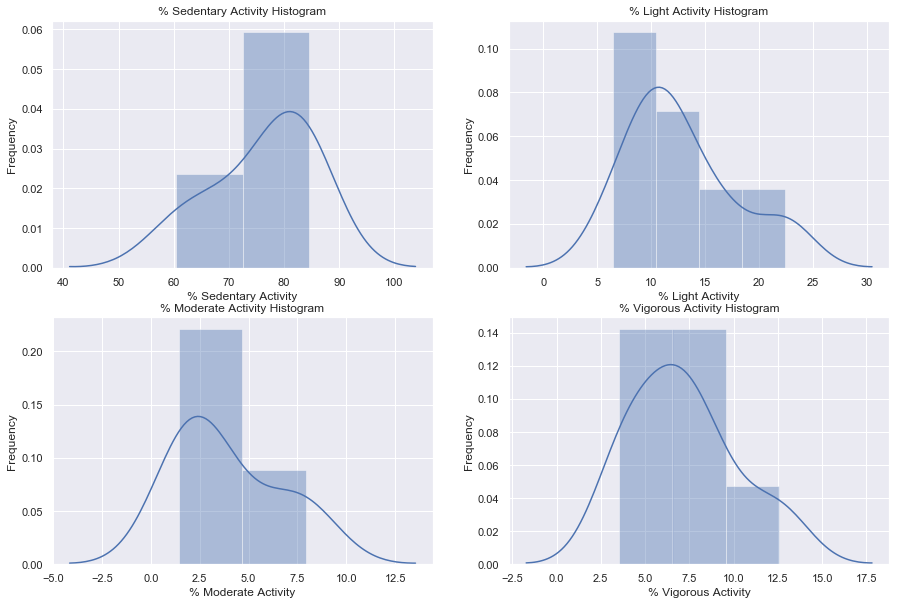

In [294]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')

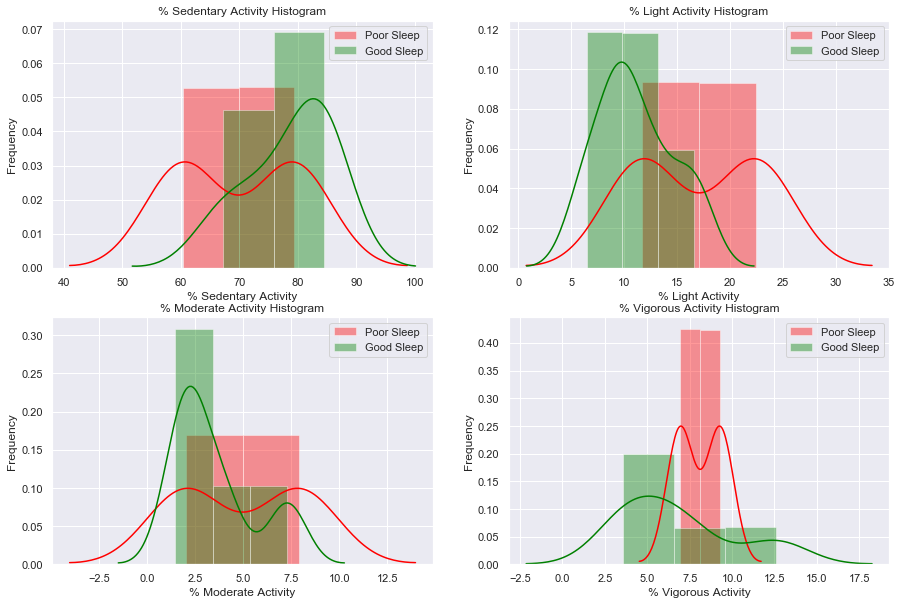

In [295]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 0], ax = ax[0, 0], color='green', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 1], ax = ax[0, 1], color='green', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 2], ax = ax[1, 0], color='green', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Poor Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 3], ax = ax[1, 1], color='green', label='Good Sleep')
ax[1, 1].set_xlabel('% Vigorous Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% Vigorous Activity Histogram')
ax[1, 1].legend()

#### Sub-Clustering on Activity Data

In [296]:
sub_clusters = activity_percentage_clusterer(TimeSeriesKMeans(num_activity_clusters, metric='dtw', max_iter=50), None, cluster_assignments, activity_percentages)

1.410 --> 0.975 --> 0.975 --> 
5.507 --> 3.319 --> 3.319 --> 
9.569 --> 6.171 --> 5.632 --> 5.193 --> 4.945 --> 4.945 --> 
0.000 --> 0.000 --> 


In [297]:
# Sanity Check for the number of points in each cluster
print(np.unique(cluster_assignments, return_counts=True))
for sub_cluster in sub_clusters:
    print(sub_cluster.shape)

(array([0, 1, 2, 3], dtype=int64), array([11, 20, 62,  7], dtype=int64))
(11,)
(20,)
(62,)
(7,)


##### Cluster Purity in each subcluster

In [298]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster
# to total number of instances in the cluster
for index, sub_cluster in enumerate(sub_clusters):
    print('Master Cluster:', index+1)
    cluster_sleep_labels = final_sleep_labels[(cluster_assignments == index)]
    for sub_cluster_assignment in range(num_activity_clusters):
        sub_cluster_sleep_labels = cluster_sleep_labels[(sub_cluster==sub_cluster_assignment)]
        try:
            pos_sleep_label_purity = sum(sub_cluster_sleep_labels) / sub_cluster_sleep_labels.shape[0]
            print(f'Sub Cluster Number: {sub_cluster_assignment}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))
        except:
            print(f'Sub Cluster Number: {sub_cluster_assignment}, No Points assigned')

Master Cluster: 1
Sub Cluster Number: 0, Purity: 0.5
Sub Cluster Number: 1, Purity: 1.0
Sub Cluster Number: 2, Purity: 1.0
Sub Cluster Number: 3, Purity: 1.0
Sub Cluster Number: 4, Purity: 1.0
Sub Cluster Number: 5, Purity: 1.0
Sub Cluster Number: 6, Purity: 1.0
Master Cluster: 2
Sub Cluster Number: 0, Purity: 0.5
Sub Cluster Number: 1, Purity: 0.5
Sub Cluster Number: 2, Purity: 0.75
Sub Cluster Number: 3, Purity: 0.5
Sub Cluster Number: 4, Purity: 0.5
Sub Cluster Number: 5, Purity: 1.0
Sub Cluster Number: 6, Purity: 1.0
Master Cluster: 3
Sub Cluster Number: 0, Purity: 0.6
Sub Cluster Number: 1, Purity: 0.7222222222222222
Sub Cluster Number: 2, Purity: 1.0
Sub Cluster Number: 3, Purity: 1.0
Sub Cluster Number: 4, Purity: 0.5
Sub Cluster Number: 5, Purity: 0.6363636363636364
Sub Cluster Number: 6, Purity: 0.5454545454545454
Master Cluster: 4
Sub Cluster Number: 0, Purity: 1.0
Sub Cluster Number: 1, Purity: 1.0
Sub Cluster Number: 2, Purity: 1.0
Sub Cluster Number: 3, Purity: 1.0
Sub Clu